# Группировка табличных данных
---

*Сделали с любовью студенты БЭК181:*

**Пешков Максим**

**Романенко Александра**

**Алтунина Анастасия**

## Вместо предисловия
---

В данном туториале __для начала__ мы показываем как установить Julia и все необходимые для работы с таблицами пакеты. __В основной части__ демонстрируется ряд операций для работы с группировкой табличных данных, выбора данных в сгруппированных датасетах, а также применение различных функций для преобразования данных.

Помимо этого, __в бонусной части__ мы показали как можно быстро визуализировать данные из сгруппированного датасета.

## Основные источники
---

* https://datatofish.com/add-julia-to-jupyter/ - *Подключение Julia к Jupyter notebook*
* https://dataframes.juliadata.org/v0.14/man/split_apply_combine.html - _Основной источник и документация_
* https://dataframes.juliadata.org/stable/man/split_apply_combine/ - *Новая версия тех же операций (по ссылке выше уже нет функции by)*
* https://github.com/nalimilan/FreqTables.jl - *frequency table*
* https://github.com/bkamins/DataFrames.jl/blob/main/docs/src/man/reshaping_and_pivoting.md - *pivot table*
* https://www.queryverse.org/VegaLite.jl/stable/gettingstarted/tutorial/ - **bonus with graphics**


## Установка Julia и необходимых пакетов
---

### Google Colaboratory
---

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.5.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots CSV Econometrics DataFrames RDatasets"
JULIA_PACKAGES_IF_GPU="CuArrays"
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

### Другие устройства
---

In [ ]:
begin
    import Pkg; Pkg.add("RDatasets")
    Pkg.add("Econometrics")
    Pkg.add("GLM")
    Pkg.add("CSV")
    Pkg.add("DataFrames")
    Pkg.add("Statistics")
    Pkg.add("FreqTables")
    Pkg.add("VegaLite")
    Pkg.add("VegaDatasets")
end

### Проверка успешной установки
---

In [ ]:
versioninfo()

Julia Version 1.5.2
Commit 539f3ce943 (2020-09-23 23:17 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, haswell)
Environment:
  JULIA_NUM_THREADS = 2


In [ ]:
exp(1) #проверка на работоспособность среды выполнения

2.718281828459045

##  Датасет
---

In [ ]:
using CSV, Econometrics, Statistics

In [ ]:
using RDatasets

In [ ]:
psid = dataset("Ecdat", "PSID")
first(psid, 5)

,IntNum,PersNum,Age,Educatn,Earnings,Hours,Kids,Married
,Int32,Int32,Int32,Int32?,Int32,Int32,Int32,Cat…
1,4,4,39,12,77250,2940,2,married
2,4,6,35,12,12000,2040,2,divorced
3,4,7,33,12,8000,693,1,married
4,4,173,39,10,15000,1904,2,married
5,5,2,47,9,6500,1683,5,married


In [ ]:
describe(psid)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,IntNum,4598.1,4,5464.0,9306,0,Int32
2,PersNum,59.2136,1,4.0,205,0,Int32
3,Age,38.4629,30,38.0,50,0,Int32
4,Educatn,16.3771,0,12.0,99,1,"Union{Missing, Int32}"
5,Earnings,14244.5,0,11000.0,240000,0,Int32
6,Hours,1235.33,0,1517.0,5160,0,Int32
7,Kids,4.48126,0,2.0,99,0,Int32
8,Married,,married,,no histories,0,"CategoricalValue{String,UInt8}"


Описание переменных:

* IntNum - номер интервью
* PersNum - персональный номер
* Age - возраст
* Educatn - количество лет обучения (получения образования)
* Hours - количество часов работы в год
* Married - семейный статус

Более подробно смотреть здесь: https://www.picostat.com/dataset/r-dataset-package-ecdat-psid

 ## Операции с данными
 ---

### `groupby(df, :variable)`


---




Делит датасет **df** на несколько датасетов, в каждом из которых категориальный признак **variable** одинаковый

Создается датасет из датасетов, далее в объяснениях __gdf__ — сгруппированный датасет

Сгруппируем наш датасет по переменной __Married__:

In [ ]:
groupby_married_psid = groupby(psid, :Married)

,IntNum,PersNum,Age,Educatn,Earnings,Hours,Kids,Married
,Int32,Int32,Int32,Int32?,Int32,Int32,Int32,Cat…
1,4,4,39,12,77250,2940,2,married
2,4,7,33,12,8000,693,1,married
3,4,173,39,10,15000,1904,2,married
4,5,2,47,9,6500,1683,5,married
5,6,4,44,12,6500,2024,2,married
6,6,172,38,16,7000,1144,3,married
7,7,170,39,12,21000,2575,3,married
8,7,171,37,11,0,0,5,married
9,10,171,47,12,22000,1920,3,married


Можно вытащить каждый i-ый датасет, вызвав команду **gdf[i]**

In [ ]:
married_psid = groupby_married_psid[1]
first(married_psid, 5)

,IntNum,PersNum,Age,Educatn,Earnings,Hours,Kids,Married
,Int32,Int32,Int32,Int32?,Int32,Int32,Int32,Cat…
1,4,4,39,12,77250,2940,2,married
2,4,7,33,12,8000,693,1,married
3,4,173,39,10,15000,1904,2,married
4,5,2,47,9,6500,1683,5,married
5,6,4,44,12,6500,2024,2,married


In [ ]:
widowed_psid = groupby_married_psid[3]
first(widowed_psid, 5)

,IntNum,PersNum,Age,Educatn,Earnings,Hours,Kids,Married
,Int32,Int32,Int32,Int32?,Int32,Int32,Int32,Cat…
1,40,5,31,12,31000,2925,0,widowed
2,57,3,35,10,0,0,2,widowed
3,575,3,39,14,8000,768,1,widowed
4,580,4,40,15,10000,1410,0,widowed
5,634,4,49,12,8150,1971,4,widowed


Или же можно вызвать, прописав условие `gdf[(variable='name'),]`

In [ ]:
first(groupby_married_psid[(Married="married",)], 5)

,IntNum,PersNum,Age,Educatn,Earnings,Hours,Kids,Married
,Int32,Int32,Int32,Int32?,Int32,Int32,Int32,Cat…
1,4,4,39,12,77250,2940,2,married
2,4,7,33,12,8000,693,1,married
3,4,173,39,10,15000,1904,2,married
4,5,2,47,9,6500,1683,5,married
5,6,4,44,12,6500,2024,2,married


In [ ]:
first(groupby_married_psid[(Married="widowed",)], 5)

,IntNum,PersNum,Age,Educatn,Earnings,Hours,Kids,Married
,Int32,Int32,Int32,Int32?,Int32,Int32,Int32,Cat…
1,40,5,31,12,31000,2925,0,widowed
2,57,3,35,10,0,0,2,widowed
3,575,3,39,14,8000,768,1,widowed
4,580,4,40,15,10000,1410,0,widowed
5,634,4,49,12,8150,1971,4,widowed


### __combine__

#### `combine(gdf, nrow)`
---

Можно вывести общее число строк в каждом датасете, используя команду **nrow**

In [ ]:
combine(groupby_married_psid, nrow)

,Married,nrow
,Cat…,Int64
1,married,3071
2,never married,681
3,widowed,90
4,divorced,645
5,separated,317
6,NA/DF,9
7,no histories,43


#### `combine(gdf, :variable => operation => :name)`
---

Выдает таблицу, где для каждого датасета **gdf[i]** в столбце с названием **name** показано значение признака **variable** после операции **operation**

Математические операции из пакета **Statistics**:
* mean - среднее значение

* median - медиана

* sum - сумма значений

* std - стандартное отклонение

По дефолту название столбца соотвествует **variable_operation**

In [ ]:
combine(groupby_married_psid, :Age => mean)

,Married,Age_mean
,Cat…,Float64
1,married,38.5718
2,never married,36.1263
3,widowed,41.5111
4,divorced,39.5938
5,separated,38.1893
6,NA/DF,38.3333
7,no histories,46.3953


Однако его можно переименовать, для этого после операции необходимо прописать `=> :new_name`

In [ ]:
combine(groupby_married_psid, :Age => mean => :mean, nrow)

,Married,mean,nrow
,Cat…,Float64,Int64
1,married,38.5718,3071
2,never married,36.1263,681
3,widowed,41.5111,90
4,divorced,39.5938,645
5,separated,38.1893,317
6,NA/DF,38.3333,9
7,no histories,46.3953,43


Аналогично выводить значения операций над признаками можно делать сразу для нескольких столбцов.

In [ ]:
combine(groupby_married_psid, :Age => mean, :Kids =>median)

,Married,Age_mean,Kids_median
,Cat…,Float64,Float64
1,married,38.5718,2.0
2,never married,36.1263,1.0
3,widowed,41.5111,3.0
4,divorced,39.5938,2.0
5,separated,38.1893,2.0
6,NA/DF,38.3333,0.0
7,no histories,46.3953,99.0


#### `combine(gdf, x -> operation(operation(vab1), operation(vab2)))`
---

Делает операции над признаками **vab1, vab2** и выводит их значения для каждого датасета **gdf[i]**

In [ ]:
combine(groupby_married_psid, x -> std(x.Hours) / std(x.Age))

,Married,x1
,Cat…,Float64
1,married,163.937
2,never married,194.89
3,widowed,193.764
4,divorced,176.545
5,separated,186.477
6,NA/DF,144.557
7,no histories,332.335


#### `combine(gdf) do df  (operations) end`
---

Можно использовать оператор **do**:

In [ ]:
combine(groupby_married_psid) do df
           (m = mean(df.Hours), s² = var(df.Hours))
       end

,Married,m,s²
,Cat…,Float64,Float64
1,married,1257.64,829583.0
2,never married,1095.27,9.88714e5
3,widowed,998.333,1.20247e6
4,divorced,1422.43,906077.0
5,separated,1086.0,9.72851e5
6,NA/DF,981.444,8.82884e5
7,no histories,704.419,1.64691e6


#### `combine(gdf, AsTable([vab1, vab2]) => x ->operations))`
---

Результат такой же, написано по-другому:

In [ ]:
combine(groupby_married_psid,
        AsTable([:Hours, :Age]) =>
        x -> std(x.Hours) / std(x.Age))

,Married,Hours_Age_function
,Cat…,Float64
1,married,163.937
2,never married,194.89
3,widowed,193.764
4,divorced,176.545
5,separated,186.477
6,NA/DF,144.557
7,no histories,332.335


#### `combine(gdf, [:vab1, :vab2] => ((p,s) ->(a = operations(p,s), b=operations(p,s))) => AsTable)`
---

Данная операция применима в том случае, если операции над признаками происходят совместно, тогда:

**vab1, vab2** - признаки

**operations** - математические операции из пакета Statistics

In [ ]:
combine(groupby_married_psid, [:Age, :Kids] => ((p, s) -> (a=mean(p)/mean(s), b=sum(p))) =>
               AsTable)

,Married,a,b
,Cat…,Float64,Int64
1,married,11.881,118454
2,never married,10.2466,24602
3,widowed,11.6025,3736
4,divorced,7.27993,25538
5,separated,9.33385,12106
6,NA/DF,57.5,345
7,no histories,0.46864,1995


#### `combine(gdf, 1:2 => cor, nrow)`
---

Выводит корреляции между признаками **vab1, vab2** для каждого из датасетов **gdf[i]**, и показывает количество элементов в них

In [ ]:
combine(groupby_married_psid, 1:2 => cor, nrow)

,Married,IntNum_PersNum_cor,nrow
,Cat…,Float64,Int64
1,married,-0.274585,3071
2,never married,-0.0749709,681
3,widowed,-0.116083,90
4,divorced,-0.178516,645
5,separated,-0.133641,317
6,NA/DF,0.240185,9
7,no histories,0.392778,43


### __select__


#### `select(df, x)`
---
Позволяет выбрать из всего датафрейма одну колонку с номером x. Если необходимо выбрать колонку по ее названию, то можно воспользоваться `select(df, :name)`

In [ ]:
first(select(married_psid, :Earnings), 5)

,Earnings
,Int32
1,77250
2,8000
3,15000
4,6500
5,6500


#### `select(df, Not(:name))`
---
Выбор всего датафрейма за исключением определенной колонки

In [ ]:
first(select(married_psid, Not(:Earnings)), 5)

,IntNum,PersNum,Age,Educatn,Hours,Kids,Married
,Int32,Int32,Int32,Int32?,Int32,Int32,Cat…
1,4,4,39,12,2940,2,married
2,4,7,33,12,693,1,married
3,4,173,39,10,1904,2,married
4,5,2,47,9,1683,5,married
5,6,4,44,12,2024,2,married


#### `select(gd, :c => operation, nrow)`
---
К сгруппированному датасету применяется операция по колонке


In [ ]:
first(select(groupby_married_psid, :Kids => sum), 10) # суммирование количества детей по катеогории Married

,Married,Kids_sum
,Cat…,Int64
1,married,9970
2,divorced,3508
3,married,9970
4,married,9970
5,married,9970
6,married,9970
7,married,9970
8,divorced,3508
9,married,9970


Такую же операцию можно применить, разделив сгруппированные датасеты с помощью `ungroup=False`, а затем вывести определенный датасет с помощью [number]

In [ ]:
select(groupby_married_psid, :Kids => sum, ungroup=false)[1]

,Married,Kids_sum
,Cat…,Int64
1,married,9970
2,married,9970
3,married,9970
4,married,9970
5,married,9970
6,married,9970
7,married,9970
8,married,9970
9,married,9970


#### `select(df, :a => (x -> operation) => :c, [:b, :f])`
---
Выбор колонки а и применение к ней определенной операции, после чего ее переименование в с. Вывод преобразованной колонки и добавление к ней колонок b и f

_Для примера переведем часы из исходного датасета в дни, поделив значения на 24, соответственно и переименуем колонку_

In [ ]:
first(select(married_psid, :Hours => (x -> /(x, 24)) => :Days, [:Educatn, :Age]), 5)

,Days,Educatn,Age
,Float64,Int32?,Int32
1,122.5,12,39
2,28.875,12,33
3,79.3333,10,39
4,70.125,9,47
5,84.3333,12,44


#### `select(df, x:y => cor)`
---
Позволяет вывести корреляцию между значениями столбцов x и y в df 

Команда `select` возвращает датафрейм с тем же количеством строк и втом же их порядке, что и в исходном датасете. Это работает даже в том случае, если в исходном сгруппированном датасете они были переупорядочены

Найдем корреляцию между уровнем образования и доходами среди женатых людей, выведем первые 5 строк

In [ ]:
first(select(married_psid, 4:5 => cor), 5)

,Educatn_Earnings_cor
,Float64
1,0.0504564
2,0.0504564
3,0.0504564
4,0.0504564
5,0.0504564


То же можно применить и к сгруппированному датасету, в таком случае помимо порядкового номера на выходе получим колонку с категорией

In [ ]:
select_cor = select(groupby_married_psid, 1:2 => cor)
first(select_cor, 10)

,Married,IntNum_PersNum_cor
,Cat…,Float64
1,married,-0.274585
2,divorced,-0.178516
3,married,-0.274585
4,married,-0.274585
5,married,-0.274585
6,married,-0.274585
7,married,-0.274585
8,divorced,-0.178516
9,married,-0.274585


### `freqtable(gdf, :x, :y)`
---




С группированными данными еще можно сделать таблицу частот по 2 признакам

Для этого нужно использовать отдельный пакет **FreqTables**

In [ ]:
import Pkg; Pkg.add("FreqTables")

In [ ]:
using FreqTables

In [ ]:
freqtable(psid, :Married, :Kids) #мне не нравится этот датасет

7×13 Named Array{Int64,2}
                                Married ╲ Kids │    0     1  …    98    99
───────────────────────────────────────────────┼──────────────────────────
CategoricalValue{String,UInt8} "married"       │  317   493  …    33     0
CategoricalValue{String,UInt8} "never married" │  261   119       12     2
CategoricalValue{String,UInt8} "widowed"       │    6    18        1     0
CategoricalValue{String,UInt8} "divorced"      │   58   128       22     0
CategoricalValue{String,UInt8} "separated"     │   21    43        5     0
CategoricalValue{String,UInt8} "NA/DF"         │    5     2        0     0
CategoricalValue{String,UInt8} "no histories"  │    0     0  …     0    43

In [ ]:
cars = dataset("datasets", "mtcars")
freqtable(cars, :Model, :Cyl)

32×3 Named Array{Int64,2}
        Model ╲ Cyl │ 4  6  8
────────────────────┼────────
AMC Javelin         │ 0  0  1
Cadillac Fleetwood  │ 0  0  1
Camaro Z28          │ 0  0  1
Chrysler Imperial   │ 0  0  1
Datsun 710          │ 1  0  0
Dodge Challenger    │ 0  0  1
Duster 360          │ 0  0  1
Ferrari Dino        │ 0  1  0
Fiat 128            │ 1  0  0
Fiat X1-9           │ 1  0  0
Ford Pantera L      │ 0  0  1
Honda Civic         │ 1  0  0
⋮                     ⋮  ⋮  ⋮
Merc 240D           │ 1  0  0
Merc 280            │ 0  1  0
Merc 280C           │ 0  1  0
Merc 450SE          │ 0  0  1
Merc 450SL          │ 0  0  1
Merc 450SLC         │ 0  0  1
Pontiac Firebird    │ 0  0  1
Porsche 914-2       │ 1  0  0
Toyota Corolla      │ 1  0  0
Toyota Corona       │ 1  0  0
Valiant             │ 0  1  0
Volvo 142E          │ 1  0  0

### `pivot table`
---

Используя метод **combine** и другие основные операции с таблицами (stack, unstack), можно вывести таблицу со средними величинами по каждому признаку для каждой категории 

In [ ]:
d = stack(psid, Not(:Married))
x = combine(groupby(d, [:variable, :Married]), :value => mean => :vsum)
unstack(x, :Married, :vsum)

,variable,married,divorced,separated,never married,widowed,no histories
,String,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,IntNum,4267.84,4692.95,5535.71,5380.64,5251.13,5944.07
2,PersNum,69.5715,46.462,38.9054,31.5624,37.4333,143.558
3,Age,38.5718,39.5938,38.1893,36.1263,41.5111,46.3953
4,Educatn,15.3312,19.338,17.4921,missing,15.8,23.9767
5,Earnings,14990.7,16486.8,10650.9,11698.2,9613.88,4390.86
6,Hours,1257.64,1422.43,1086.0,1095.27,998.333,704.419
7,Kids,3.2465,5.43876,4.09148,3.5257,3.57778,99.0


### *__Бонус__: красивый график с группированными данными
---

In [ ]:
import Pkg; Pkg.add("VegaLite")

In [ ]:
using RDatasets, VegaLite
iris = dataset("datasets", "iris")

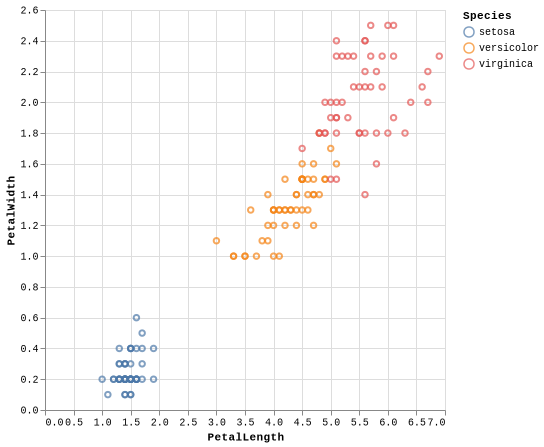

In [ ]:
iris |> @vlplot(
  :point,
  x=:PetalLength,
  y=:PetalWidth,
  color="Species:n",
  width = 400,
  height=400
)

### ** __Бонус__: еще более красивые графики 
---


Так как пакеты **VegaDatasets, RDatasets** конфликтуют, поэтому используем VegaDatasets.dataset

In [ ]:
import Pkg; Pkg.add("VegaLite")

In [ ]:
import Pkg; Pkg.add("VegaDatasets")

In [ ]:
using VegaDatasets, VegaLite

data = VegaDatasets.dataset("cars")

┌ Info: Precompiling VegaDatasets [0ae4a718-28b7-58ec-9efb-cded64d6d5b4]
└ @ Base loading.jl:1278
┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1278


Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
"""chevrolet chevelle malibu""",18.0,8,307.0,130,3504,12.0,"""1970-01-01""","""USA"""
"""buick skylark 320""",15.0,8,350.0,165,3693,11.5,"""1970-01-01""","""USA"""
"""plymouth satellite""",18.0,8,318.0,150,3436,11.0,"""1970-01-01""","""USA"""
"""amc rebel sst""",16.0,8,304.0,150,3433,12.0,"""1970-01-01""","""USA"""
"""ford torino""",17.0,8,302.0,140,3449,10.5,"""1970-01-01""","""USA"""
"""ford galaxie 500""",15.0,8,429.0,198,4341,10.0,"""1970-01-01""","""USA"""
"""chevrolet impala""",14.0,8,454.0,220,4354,9.0,"""1970-01-01""","""USA"""
"""plymouth fury iii""",14.0,8,440.0,215,4312,8.5,"""1970-01-01""","""USA"""
"""pontiac catalina""",14.0,8,455.0,225,4425,10.0,"""1970-01-01""","""USA"""
"""amc ambassador dpl""",15.0,8,390.0,190,3850,8.5,"""1970-01-01""","""USA"""


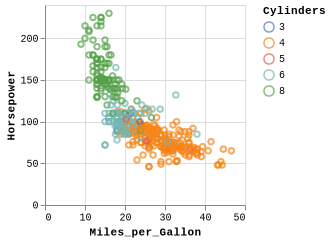

In [ ]:
data |>
@vlplot(:point, x=:Miles_per_Gallon, y=:Horsepower, color="Cylinders:n")

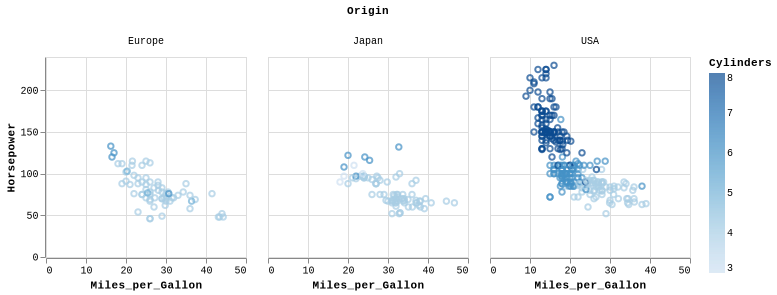

In [ ]:
data |>
@vlplot(:point, x=:Miles_per_Gallon, y=:Horsepower, column=:Origin, color=:Cylinders)